### Importar librerías cirq y qsimcirq

In [191]:
try:
    import cirq
except ImportError:
    !pip install cirq
    import cirq

try:
    import qsimcirq
except ImportError:
    !pip install qsimcirq
    import qsimcirq

# PORTER THOMAS

In [277]:
def porter_thomas_distribution(probabilities, n_qubits):
    N = 2**n_qubits  # Número total de estados
    Np = probabilities * N  # Rescalamos las probabilidades
    hist, bin_edges = np.histogram(Np, bins=50, density=True)  # Histograma normalizado
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Centros de los bins
    return centers, hist

In [8]:
import cirq
import qsimcirq 
import numpy as np

#patron del circuito 1D
pattern_1D = [
    cirq.experiments.GridInteractionLayer(
        col_offset=0,
        vertical=True,
        stagger=True
    ),
    cirq.experiments.GridInteractionLayer(
        col_offset=1,
        vertical=True,
        stagger=True
    )
]

#para la iswap descomentar esto y las lineas correspondiente en la función random_circuits_normal
#two_qubit_op_factory = lambda q0, q1, prng: cirq.ISwapPowGate(exponent=0.5)(q0, q1)

#función para generar el circuito aleatorio con ruido
def random_circuits_normal(qubits, nr_layers, grid_type):
   
    if grid_type == '1D':
        circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(
            qubits=qubits,
            depth=nr_layers,
            pattern=pattern_1D,
            #two_qubit_op_factory=two_qubit_op_factory,
            add_final_single_qubit_layer=False
        )
    elif grid_type == '2D':
        circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(
            qubits=qubits,
            depth=nr_layers,
            pattern=cirq.experiments.GRID_STAGGERED_PATTERN, #patron ABCDCDAB
            #two_qubit_op_factory=two_qubit_op_factory,
            add_final_single_qubit_layer=False
        )

    return circuit_google
    
#funcion para introducir ruido en el circuito
def introduce_noise(circuit,qubits, error, error_type):
    if error == 0:
        return circuit

    base_moments = list(circuit)
    new_circuit = cirq.Circuit()

    for idx, moment in enumerate(base_moments):
        # Añadimos la capa original
        new_circuit.append(moment)

        # Detectamos qué qubits estuvieron activos usando moment.qubits
        active = set(moment.qubits)

        if not active:
            continue  # nada de ruido si no hubo puertas

        # Elegimos r1 según índice de capa
        r1 = (error/10) if (idx % 2 == 0) else error

        # Decidimos si aplicamos el error a toda la capa
        if np.random.rand() < r1:
            if error_type == 'depolarization':
                # misma puerta para todos los activos
                gate = np.random.choice([cirq.X, cirq.Y, cirq.Z])
                ops = [gate.on(q) for q in active]

            elif error_type == 'amplitude_damping':
                ops = [cirq.amplitude_damp(gamma=r1).on(q) for q in active]

            else:
                raise ValueError(f"Unknown error_type: {error_type}")

            noise_moment = cirq.Moment(ops)
            # Insertamos el momento de ruido justo después
            new_circuit.append(noise_moment)

    return new_circuit


# Inicializamos las opciones para el hardware de simulación
# Option 1 (mode=0) or Option 2 (mode=1)
# Option 3 (number of GPUs = `num_gpus`)
gpu_options = qsimcirq.QSimOptions(cpu_threads=4, use_gpu=False, gpu_mode = 0, max_fused_gate_size=3)
qsim_simulator = qsimcirq.QSimSimulator(qsim_options=gpu_options)

#-------------------------------------------------------

#valores iniciales
nr_qubits=12 #para 2D, poner nr_qubits=5 si se quiere una cuadrícula de 5x4
nr_layers=15
repeticiones=1000  #número de veces que se simula el circuito aleatorio
grid_type='1D'
epsilon = [0, 0.01,0.03,0.05] #ruido
noise_type='depolarization' #depolarization or amplitude_damping

if grid_type == '1D':
    qubits = [cirq.GridQubit(i, 0) for i in range(nr_qubits)]
    result = np.zeros((len(epsilon), 2**(nr_qubits)))
elif grid_type == '2D':
    qubits = [cirq.GridQubit(i, j) for i in range(nr_qubits) for j in range(nr_qubits-1)]
    result = np.zeros((len(epsilon), 2**(nr_qubits*(nr_qubits-1))))


circuit = random_circuits_normal(qubits, nr_layers, grid_type)

#print(circuit)
for r in range(repeticiones):

  for idx, e in enumerate(epsilon):
    noisy_circuit=introduce_noise(circuit, qubits, e, noise_type)
    noisy_circuit.insert(0, cirq.H.on_each(*qubits))
    
    #print("Circuito simulado:")
    #print(noisy_circuit)

    result[idx]+=np.abs(qsim_simulator.simulate(noisy_circuit).final_state_vector)**2 

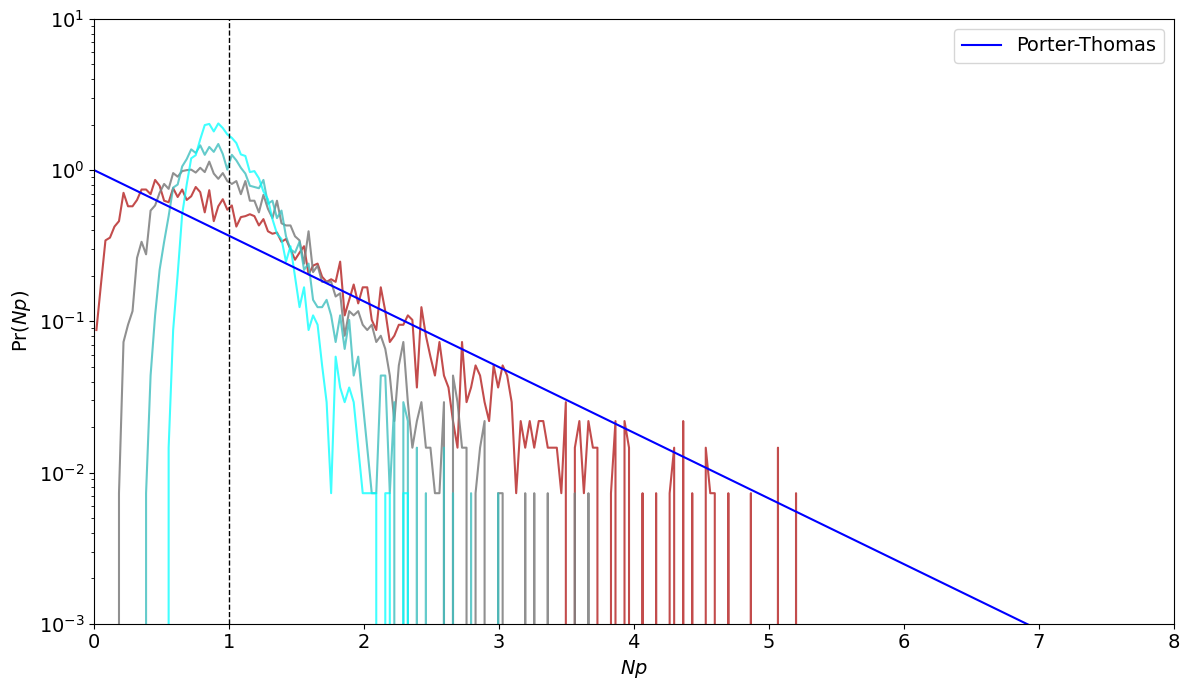

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Inicializar los parámetros
N = 2**nr_qubits  # Número total de estados
bin_edges = np.linspace(0, 10, 300)  # Dividir las probabilidades en 300 bins
widths = bin_edges[1:] - bin_edges[:-1]

# Crear el gráfico
fig=plt.figure(figsize=(12, 7))



# Procesar los datos de `result` para cada nivel de ruido
i=1
for e, probabilities in zip(epsilon, result):
    hist, _ = np.histogram(probabilities * N/repeticiones, bins=bin_edges)  # Calcular histograma
    norma=sum(hist*widths)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calcular los centros de los bins
    color_param=i/len(epsilon)  # Invertir el orden para que el primer color sea el más oscuro
    color = (1.0-color_param, 0.0 + color_param, 0.0 + color_param, 1 - color_param/4)
    i+=1
    plt.plot(bin_centers, hist/norma,color=color, linestyle='-')


# Configuración del gráfico
#plt.title("Cantidad de Estados vs Probabilidad (con Ruido)")
plt.xlabel(r"$Np$", fontsize=14)
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.ylabel(r"Pr($Np$)", fontsize=14)
plt.xlim(-0, 8)  # Ajustar el límite del eje X
plt.ylim(0.001, 10)  # Ajustar el límite del eje Y
plt.grid(False)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#dibujo una linea vertical en x=1
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)

#pinto la recta porter thomas para comparar PT=e^(-N*P) sin usar la funcion
x = np.linspace(0, 10, 5)
y = np.exp(-x)
plt.plot(x, y, label='Porter-Thomas', color='blue', linestyle='-')


plt.legend(fontsize=14, loc='upper right')
plt.show()


# Mi código OTOCS 

### Funciones

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cirq
import qsimcirq 


#patron del circuito 1D
pattern_1D = [
    cirq.experiments.GridInteractionLayer(
        col_offset=0,
        vertical=True,
        stagger=True
    ),
    cirq.experiments.GridInteractionLayer(
        col_offset=1,
        vertical=True,
        stagger=True
    )
]

#funcion que añade el qubit auxiliar en q0
def ancilla(circuit: cirq.Circuit) -> cirq.Circuit:
    # Definimos un qubit ancilla, donde se mide el otoc
    anc= cirq.GridQubit(0, 0)  

    # Añadimos el qubit: una identidad sobre el ancilla en un nuevo momento 
    circuit.insert(0, cirq.I(anc))

    return circuit


#para la iswap
#two_qubit_op_factory = lambda q0, q1, prng: cirq.ISwapPowGate(exponent=0.5)(q0, q1)

#función para generar el circuito aleatorio con ruido
def random_circuits(qubits, nr_layers, grid_type):
   
    if grid_type == '1D':
        circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(
            qubits=qubits,
            depth=nr_layers,
            pattern=pattern_1D,
            #two_qubit_op_factory=two_qubit_op_factory,
            add_final_single_qubit_layer=False
        )
    elif grid_type == '2D':
        circuit_google = cirq.experiments.random_rotations_between_grid_interaction_layers_circuit(
            qubits=qubits,
            depth=nr_layers,
            pattern=cirq.experiments.GRID_STAGGERED_PATTERN,
            #two_qubit_op_factory=two_qubit_op_factory,
            add_final_single_qubit_layer=False
        )
    circuit_google = ancilla(circuit_google)
    return circuit_google
    
    
#funcion para introducir ruido en el circuito
def introduce_noise(circuit,qubits, error, error_type):
    if error == 0:
        return circuit

    base_moments = list(circuit)
    new_circuit = cirq.Circuit()

    for idx, moment in enumerate(base_moments):
        # Añadimos la capa original
        new_circuit.append(moment)

        # Detectamos qué qubits estuvieron activos usando moment.qubits
        active = set(moment.qubits)

        if not active:
            continue  # nada de ruido si no hubo puertas

        # Elegimos r1 según índice de capa
        r1 = (error/10) if (idx % 2 == 0) else error

        # Decidimos si aplicamos el error a toda la capa
        if np.random.rand() < r1:
            if error_type == 'depolarization':
                # misma puerta para todos los activos
                gate = np.random.choice([cirq.X, cirq.Y, cirq.Z])
                ops = [gate.on(q) for q in active]

            elif error_type == 'amplitude_damping':
                ops = [cirq.amplitude_damp(gamma=r1).on(q) for q in active]

            else:
                raise ValueError(f"Unknown error_type: {error_type}")

            noise_moment = cirq.Moment(ops)
            # Insertamos el momento de ruido justo después
            new_circuit.append(noise_moment)

    return new_circuit

    
    
    
#funcion que genera U^dagger
def inverse_circuit(circuit: cirq.Circuit) -> cirq.Circuit:
    inverse_circuit = cirq.Circuit()
    
    # Recorremos las capas (moments) en orden inverso
    for moment in reversed(circuit):
        
        inverse_ops = []
       
        # Cada operación la invertimos 
        for op in moment.operations:
            # cirq.inverse(op) produce la operación inversa si existe
            inv_op = cirq.inverse(op, None)
            inverse_ops.append(inv_op)
        
        # Añadimos la capa inversa al circuito
        inverse_circuit.append(inverse_ops)
    
    return inverse_circuit

#definimos la funcion principal, que construye el circuito para estudiar la evolucion del otoc
def OTOC_circuit( nr_qubits, nr_layers, error,error_type, grid_type, O_operator, O_position, M_operator):

    if grid_type == '1D':
        qubits = [cirq.GridQubit(i, 0) for i in range(1, nr_qubits+1)]
     
    elif grid_type == '2D':
        qubits = [cirq.GridQubit(0, j) for j in range(1, nr_qubits-1)] + [cirq.GridQubit(i, j) for i in range(1, nr_qubits) for j in range(0, nr_qubits-1)]+[cirq.GridQubit(nr_qubits, 0)] # Qubits en una cuadr�cula 2D
    
    
    # Creamos el circuito
    circuit_ini = random_circuits(qubits, nr_layers, grid_type)

    #para la simulacion con ruido
    circuit = introduce_noise(circuit_ini, qubits, error, error_type)

    #Calculamos el circuito inverso
    circuit_inverso = introduce_noise(circuit_ini, qubits, error, error_type)
    circuit_dagger=inverse_circuit(circuit_inverso)

    qubits = sorted(circuit.all_qubits(), key=lambda q: (q.row, q.col))
    #Introducimos el operador que evoluciona en el tiempo O(t)
    circuit.append(O_operator(qubits[O_position]))

    #Añadimos U^dagger
    circuit.append(circuit_dagger)

  
    
    #Añadimos el operador M sobre q1 entrelazado con el qubit ancilla
    circuit.insert(0,M_operator(cirq.GridQubit(0, 0),cirq.GridQubit(0, 1))) #cambiar el qubit a (1,0) en 1D o (0,1) en 2D
    circuit.append(M_operator(cirq.GridQubit(0, 0),cirq.GridQubit(0, 1)))

    
    circuit.insert(1, cirq.Moment())
    circuit=ancilla(circuit)  # Añadimos el qubit ancilla al circuito

    return circuit

In [33]:
####################### Main ##########################

# Inicializamos las opciones para el hardware de simulacion
# Option 1 (mode=0) or Option 2 (mode=1)
# Option 3 (number of GPUs = `num_gpus`)
gpu_options = qsimcirq.QSimOptions(cpu_threads=16, use_gpu=False, gpu_mode = 0, max_fused_gate_size=4)
qsim_simulator = qsimcirq.QSimSimulator(qsim_options=gpu_options)


# Parametros
nr_circuits=50
nr_layers_max=10
nr_qubits=3
error=0.01
grid_type='2D' #1D or 2D
error_type='depolarization' #depolarization or amplitude_damping


In [34]:
results = []
for O_position in range(1,(nr_qubits)*(nr_qubits-1)): #cambiar el rango (nr_qubits)*(nr_qubits-1) para 2D y nr_qubits para 1D
    exp_values_medio=[]
    for nr_layers in range(1, nr_layers_max+1):
        total=0
        for cirqu in range(nr_circuits):
            #genero el circuito
            circuit=OTOC_circuit(nr_qubits, nr_layers, error, error_type, grid_type, cirq.X, O_position, cirq.CZ)

            #qubit ancilla en +Y
            qubits = sorted(circuit.all_qubits(), key=lambda q: (q.row, q.col))
            circuit.insert(0,[ cirq.H(qubits[0]),cirq.S(qubits[0])])
            #el resto en +X
            for q in qubits[1:]:
                circuit.insert(0,cirq.H(q))
            #medimos el observable Y en el qubit ancilla
            obs = cirq.Y(qubits[0])
            exp_val = qsim_simulator.simulate_expectation_values(circuit, observables=[obs])[0].real
            total += exp_val

        exp_values_medio.append(total/nr_circuits)
    results.append(exp_values_medio) 


print(circuit)

                                               ┌──┐                   ┌──┐                                                                                                   ┌──┐                   ┌──┐                   ┌──┐                   ┌──┐   ┌───────────────┐                    ┌───────────────┐            ┌───────┐                    ┌───────┐                                                                                                                  ┌───────┐                    ┌───────┐
(0, 0): ───H───S───I───@───────I──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────I───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### sin O(t):

In [35]:
#------------- Sin O(t) -----------------------------
results_sin_O=[]
for nr_layers in range(1, nr_layers_max+1):
    total=0
    for cirqu in range(nr_circuits):
        #genero el circuito
        circuit=OTOC_circuit(nr_qubits, nr_layers, error, error_type, grid_type, cirq.X, O_position, cirq.CZ)

        #qubit ancilla en +Y
        qubits = sorted(circuit.all_qubits(), key=lambda q: (q.row, q.col))
        circuit.insert(0,[ cirq.H(qubits[0]),cirq.S(qubits[0])])
        #el resto en +X
        for q in qubits[1:]:
            circuit.insert(0,cirq.H(q))

        #calculo el valor esperado de pauli_y en el qubit ancilla
        """
        ps = cirq.Y(qubits[0])  
        sim = cirq.Simulator()
        exp_values = sim.simulate_expectation_values(circuit, observables=[ps])
        #print("Valor esperado de Y =", exp_values[0])
        total+=np.real(exp_values[0])
        """
        obs = cirq.Y(qubits[0])
        exp_val = qsim_simulator.simulate_expectation_values(circuit, observables=[obs])[0].real

        total += exp_val
    results_sin_O.append(total/nr_circuits)


### Plot < Y >

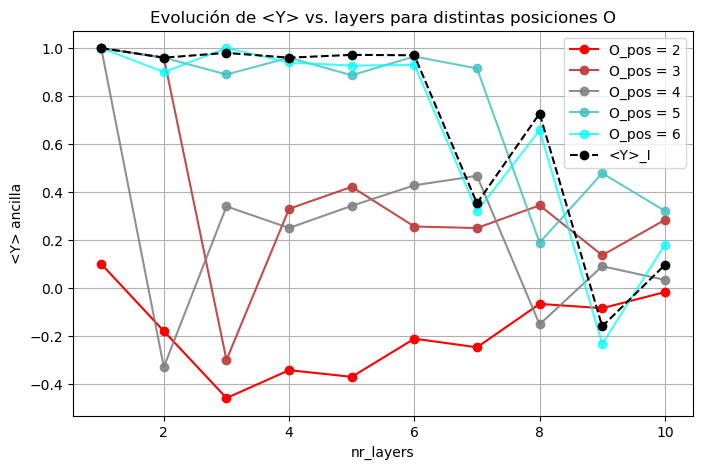

In [38]:
fig=plt.figure(figsize=(8,5))

xvals = range(1, nr_layers_max+1)
color_param=1.0/(O_position-1)

for idx, yvals in enumerate(results):
    # O_position real = 2 + idx
    label_str = f"O_pos = {2 + idx}"
    color = (1.0-idx*color_param, 0.0 + idx * color_param, 0.0 + idx*color_param, 1 - idx * color_param/4)
    plt.plot(xvals, yvals, 'o-',color=color, label=label_str)


plt.plot(xvals, results_sin_O, 'o--',color=(0.0, 0, 0.0, 1 ), label="<Y>_I")

plt.xlabel("nr_layers")
plt.ylabel("<Y> ancilla")
plt.title("Evolución de <Y> vs. layers para distintas posiciones O")
plt.grid(True)
plt.legend()
location="C:\\Users\\aileo\\environments\\TFG\\TFM\\OTOCS"
if error==0:
    fig.savefig(f'{location}/otoc_Y_q{nr_qubits}_e{error}_c{nr_circuits}_fig1C-Apaper.pdf')
else:
    fig.savefig(f'{location}/otoc_Y_q{nr_qubits}_{error_type}_e{error}_c{nr_circuits}_fig1C-Apaper.pdf')
plt.show()